# MAKİNE ÖĞRENMESİ PROJE ÖDEVİ - 1
## Konu: Transfer Learning (VGG16) ile Görüntü Sınıflandırma

**Adı Soyadı:** Özge Zara Özçelik
**Numara:** 2212721014
**GitHub Repo:** [Link]

---
### 1. Giriş ve Amaç
Bu projede, elimizdeki veri setiyle yüksek doğruluklu bir görüntü sınıflandırma modeli geliştirmek amaçlanmıştır. Sıfırdan bir CNN (Evrişimli Sinir Ağı) eğitmek yerine, daha az veriyle daha yüksek başarı sağlayan **Transfer Learning (Aktarım Öğrenmesi)** yöntemi tercih edilmiştir.

Model olarak, ImageNet veri setinde milyonlarca görüntüyle eğitilmiş **VGG16** mimarisi kullanılmıştır.

**Kullanılan Yöntemler:**
1.  **Veri Artırma ve Ön İşleme:** Görüntülerin VGG16 standardına (224x224) getirilmesi ve normalize edilmesi.
2.  **Feature Extraction (Öznitelik Çıkarımı):** VGG16'nın evrişim katmanları dondurularak (freezing) sadece sınıflandırma katmanının eğitilmesi.
3.  **Regularization (Düzenlileştirme):** Aşırı öğrenmeyi (Overfitting) önlemek için Dropout katmanı eklenmesi.

### 1. Kütüphanelerin Yüklenmesi ve Veri Seti Hazırlığı
Projede derin öğrenme modeli oluşturmak için **TensorFlow** ve **Keras** kütüphaneleri kullanılmıştır. Veri setine erişim sağlamak için Google Drive bağlantısı yapılmış (`drive.mount`) ve gerekli görselleştirme araçları (`matplotlib`) tanımlanmıştır.

**Veri Ön İşleme (Data Preprocessing):**
* **Yeniden Ölçeklendirme (Rescaling):** Görüntü pikselleri 0-255 aralığından 0-1 aralığına normalize edilmiştir. Bu işlem modelin daha hızlı ve kararlı öğrenmesini sağlar.
* **Boyutlandırma (Resizing):** Kullanılacak olan **VGG16** modeli, orijinalinde 224x224 piksel boyutunda görüntülerle eğitilmiştir. Transfer Learning (Aktarım Öğrenmesi) verimliliğini artırmak amacıyla veri setindeki tüm görüntüler **224x224** boyutuna getirilmiştir.
* **Veri Ayrımı:** Veri seti %80 Eğitim (Training) ve %20 Doğrulama (Validation) olacak şekilde ayrılmıştır.

In [ ]:
# 1. Drive ve Kütüphaneler
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# 2. Veri Yolu (Klasör ismin)
base_dir = '/content/drive/My Drive/makine_ogrenmesi_veriseti'

# 3. Grafik Çizme Fonksiyonu
def grafik_ciz(history, model_adi):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title(f'{model_adi} - Doğruluk')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title(f'{model_adi} - Kayıp')
    plt.legend()
    plt.show()

# 4. GÜNCELLENMİŞ VERİ YÜKLEME (224x224)
# VGG16'nın gerçek gücünü göstermesi için boyutu büyüttük
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224), # DEĞİŞİKLİK BURADA: 128 yerine 224
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 359 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


2. VGG16 Mimarisi ve Overfitting Önlemleri

Projede temel model olarak VGG16 kullanılmış ve Transfer Learning (Transfer Öğrenimi) yöntemiyle şu yapılandırmalar uygulanmıştır:

Feature Extraction (Özellik Çıkarımı): Modelin evrişimsel tabanı dondurulmuş (trainable=False), böylece modelin önceden öğrendiği temel görsel özellikler (kenar, doku vb.) korunmuştur.

Overfitting (Ezberleme) Önlemleri: Veri setinin kısıtlı boyutu (~360 görüntü) nedeniyle oluşabilecek ezberleme sorununa karşı sınıflandırma katmanında iki kritik optimizasyon yapılmıştır:

Düşürülmüş Kapasite (Dense 64): Modelin gereksiz detayları ezberlemesini önlemek adına nöron sayısı 64 ile sınırlandırılmıştır.

Dropout (0.2): Her eğitim adımında nöronların %20'si kapatılarak modelin gürültüye karşı dayanıklılığı ve genelleme başarısı artırılmıştır.

In [ ]:
# --- MODEL 1: VGG16 (224x224 GİRİŞLİ) ---

# 1. VGG16'yı 224x224 girişiyle çağır (DEĞİŞİKLİK BURADA)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Ağırlıkları Dondur
for layer in base_model.layers:
    layer.trainable = False

# 3. Katmanları Ekle
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x) # 64 Nöron (Ezberi önlemek için)
x = Dropout(0.5)(x)                 # %50 Unutma (Dropout'u artırdık)
predictions = Dense(2, activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

# 4. Derle
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Eğit
print("Model 1 (224x224 Çözünürlük) Eğitiliyor...")
history1 = model1.fit(train_generator, validation_data=validation_generator, epochs=10)


Model 1 (224x224 Çözünürlük) Eğitiliyor...
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.7193 - loss: 1.2202 - val_accuracy: 0.8750 - val_loss: 0.2446
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9401 - loss: 0.1249 - val_accuracy: 0.8750 - val_loss: 0.1806
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9904 - loss: 0.0815 - val_accuracy: 0.9205 - val_loss: 0.2521
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 1.0000 - loss: 0.0351 - val_accuracy: 0.8750 - val_loss: 0.2671
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9879 - loss: 0.0331 - val_accuracy: 0.8636 - val_loss: 0.2674
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.9878 - loss: 0.0408 - val_accuracy: 0.8636 - val_loss: 0.2741
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9917 - loss: 0.0428 - val_accuracy: 0.8523 - val_loss: 0.2732
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.9977 - loss

### 3. Performans Analizi ve Sonuçların Görselleştirilmesi
Modelin eğitimi tamamlandıktan sonra elde edilen `history` verileri kullanılarak **Başarı (Accuracy)** ve **Yitim (Loss)** grafikleri çizdirilmiştir.

* **Grafiklerin Amacı:** Eğitim (Training) ve Doğrulama (Validation) eğrilerinin birbirine yakınlığı incelenerek modelin "Overfitting" (ezberleme) yapıp yapmadığı kontrol edilir. İdeal durumda bu iki çizgi birbirine yakın ve paralel ilerlemelidir.
* **Nihai Sonuç:** Modelin son epoch sonundaki test doğruluğu (Validation Accuracy) ekrana yazdırılır. Bu değer, projenin en sonunda oluşturulacak **Karşılaştırma Tablosu** için kullanılacaktır.

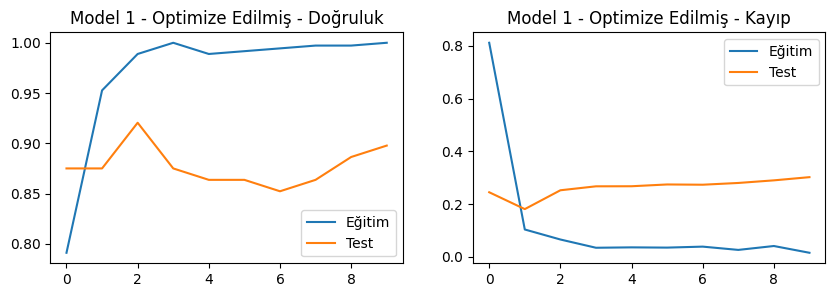

Model 1 Final Test Doğruluğu: 0.8977272510528564


In [ ]:
grafik_ciz(history1, "Model 1 - Optimize Edilmiş")

# Sonucu yazdır
print("Model 1 Final Test Doğruluğu:", history1.history['val_accuracy'][-1])